In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using RPQN with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [L^2(0,1)]^3} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|_2^2 + \frac{\vartheta}{2} \| \rho(T) - \widehat{\rho}(T) \|^2_{\R^3},
\end{align}
where $\rho = (\begin{smallmatrix} \sigma & I & R & D \end{smallmatrix})$ comes from the solution of a change of variables applied to the Susceptibles, Infected, Recovered, and Deceased (SIRD) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameters $\theta$ and $\vartheta$ are non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha = (\beta, \gamma, m) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the four variables $S(t)$, $I(t)$, $R(t)$, and $D(t)$ are governed by the following differential equations
    
\begin{align}
    \tag{$\star$}
\begin{aligned}
    \frac{\dif \sigma}{\dif t} &= a_1\beta (\mathsf{n} - \sigma) I,
    \\
    \frac{\dif I}{\dif t} &= a_1\beta (\mathsf{n} - \sigma) I - (a_2\gamma + a_3 m) I,
    \\
    \frac{\dif R}{\dif t} &= a_2\gamma I,
    \\
    \frac{\dif D}{\dif t} &= a_3 m I.
\end{aligned}
\end{align}
We note that $ \mathsf{n} $ is the total population at the start of the study.
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import gurobipy as GRB
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones, eye, empty, append, diagflat, tril, triu
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson, trapezoid
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline, interp1d
from scipy.sparse.linalg import LinearOperator
from scipy.sparse    import eye as speye
from scipy.sparse    import bmat
from numpy.polynomial.chebyshev import chebpts1
from matplotlib import colormaps

# Model scaling

We scale the baseline original ODE system for the SIRD model. Assuming $\overline{\rho}(\tau)$ satisfies the original SIRD ODE system above with parameters $\overline\alpha = (\overline\beta, \overline\gamma, \overline{m})$ and initial condition $\overline{\rho}_0$, then $(\star)$ above is related with $\overline{\rho}$ via the relationships

* Population scaling: $\overline{\rho} = s_1 \rho$, where $ \rho_{\mathsf{S}} = \mathsf{n} - \sigma $,

* Time scaling: $\tau = s_2 t$,

* Parameter scalings: $\overline{\alpha} = \left( \frac{a_1}{s_1 s_2} \beta, \frac{a_2}{s_2} \gamma, \frac{a_3}{s_2} m \right)$.

# Data loading

We load data used in [[1]](https://doi.org/10.1016/j.rico.2023.100346). Locally, we have stored data of susceptible, infected, recovered, and deceased compartments from June 1 – July 20, 2021. When constructing the dataset, the total population size $\mathsf{n}$ was set to 164\,689\,383 given by an estimate from [[3]](https://www.worldometers.info/world-population/bangladesh-population/). We will set $\mathsf{n}$ to be equal to the total number of people at the initial time.

In [4]:
SIRD_data = pd.read_pickle('BD_2021_Jun_Jul.pkl').values.astype('float64')

In [5]:
print('𝗇̄: {0:.0f}'.format(np.unique(SIRD_data.sum(1)).item()))

𝗇̄: 164689383


In [6]:
σ_data = SIRD_data.sum(1) - SIRD_data[:,0]

In [7]:
ΣIRD_data = np.c_[σ_data, SIRD_data[:,1:]]      # Determine σ and remove S compartment

In [8]:
int(ΣIRD_data.max()), int(SIRD_data.max())      # There is quite a difference in order of magnitude

(22887, 164686226)

The data considers reports spanning 60 days. 

In [9]:
T = np.float64(ΣIRD_data.shape[0])

**Scales**

We will group the observations by week and label the initial week by $0$; i.e., $s = 7$ and $T = 50/7 \approx 7$. We will scale people by the maximum expected value of the residual susceptibles $\sigma$:

In [10]:
time_scale = 7.0                 # s_2
ppl_scales = ΣIRD_data.max();    # s_1

In [11]:
T /= time_scale                        # Scale time
ΣIRD_data /= ppl_scales                # Scale population: (helps in computation time)

In [12]:
# Make an interval span
Tᵒᵇˢ  = linspace(0,T,SIRD_data.shape[0])

We build a piecewise interpolator for computing any integral terms:

In [13]:
Tₑ = 0.5*(chebpts1(152-2+1)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])         # Add endpoints
# Add observed points
Tₑ = np.unique(np.sort(concatenate([Tₑ,Tᵒᵇˢ])))

In [14]:
Tₑ.size    # odd number of collocation points for Simpson

201

In [15]:
ρ̄ = interp1d(Tᵒᵇˢ,ΣIRD_data[:,].T, axis=-1, kind = 'quadratic')
ρ̂ = ρ̄(Tₑ)

In [16]:
ρ̄(0).sum()

0.3132782802464281

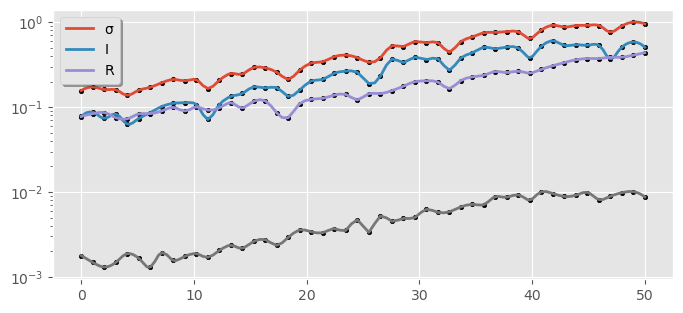

In [17]:
# Plot data
plt.figure(figsize=(8,3.5))

plt.plot(Tₑ*time_scale, ρ̂.T, '-', linewidth=2)
for i in range(4):
    plt.scatter(Tᵒᵇˢ*time_scale, ΣIRD_data[:,i], s=10, c='black')
plt.yscale('log')

plt.legend(['σ', 'I', 'R'], shadow=True)
plt.show()

Compare numerical ranges for different scales:

In [18]:
# Original data:
lows = np.min(SIRD_data, 0);    ups  = np.max(SIRD_data, 0);    strs = ['S̄', 'Ī', 'R̄', 'D̄']
for i in range(4):
    print('{0:9.0f} ≤ {1:s} ≤ {2:.0f}'.format(lows[i], strs[i], ups[i]))

164666496 ≤ S̄ ≤ 164686226
     1447 ≤ Ī ≤ 13768
     1667 ≤ R̄ ≤ 9997
       30 ≤ D̄ ≤ 231


In [19]:
# Scaling by total population is not that good:
lows = np.min(SIRD_data, 0)/SIRD_data[0].sum();    ups  = np.max(SIRD_data, 0)/SIRD_data[0].sum();    strs = ['S̄', 'Ī', 'R̄', 'D̄']
for i in range(4):
    print('{0:.4e} ≤ {1:s} ≤ {2:.4e}'.format(lows[i], strs[i], ups[i]))

9.9986e-01 ≤ S̄ ≤ 9.9998e-01
8.7862e-06 ≤ Ī ≤ 8.3600e-05
1.0122e-05 ≤ R̄ ≤ 6.0702e-05
1.8216e-07 ≤ D̄ ≤ 1.4026e-06


In [20]:
# σIR data is well behaved:
lows = np.min(ΣIRD_data, 0);    ups  = np.max(ΣIRD_data, 0);    strs = ['σ̄', 'Ī', 'R̄', 'D̄']
for i in range(4):
    print('{0:.3f} ≤ {1:s} ≤ {2:.3f}'.format(lows[i], strs[i], ups[i]))

0.138 ≤ σ̄ ≤ 1.000
0.063 ≤ Ī ≤ 0.602
0.073 ≤ R̄ ≤ 0.437
0.001 ≤ D̄ ≤ 0.010


We see that the $\sigma \mathsf{IR}$ model is better scaled by compartment and explicitly shows the evolution of $\sigma$. In contrast, the susceptible compartment in the original model might give the impression that it is a constant.

### Prior information

In the original paper, the authors obtained the following constant–in–time estimates:

In [21]:
print('β̂: {0:.15f}, γ̂: {1}, m̂: {2}'.format(0.0706 / 164689383, 0.0257, 0.0011))

β̂: 0.000000000428686, γ̂: 0.0257, m̂: 0.0011


Using the current scales, we obtain the better behaved values:

In [22]:
print('β̂: {0:.8f}, γ̂: {1}, m̂: {2}'.format(ppl_scales * time_scale * 0.0706 / 164689383, time_scale * 0.0257, time_scale * 0.0011))

β̂: 0.00006868, γ̂: 0.1799, m̂: 0.0077


We notice that $\beta$ and $\gamma$ are still very small. So we can use $a_1 = 10^{-4}$, $a_2 = 1$, and $a_3 = 10^{-2}$ to obtain:

In [23]:
aᵦ = 1e-4;    aᵧ = 1.0;    aₘ = 1e-2
print('β̂: {0:.8f}, γ̂: {1}, m̂: {2}'.format(ppl_scales * time_scale * 0.0706 / (164689383 * aᵦ), time_scale * 0.0257/aᵧ, time_scale * 0.0011/aₘ))

β̂: 0.68679323, γ̂: 0.1799, m̂: 0.77


### Bounds

Without bounds, the range of each parameter at any given time is given by:

In [24]:
print('uᵦ: {0:.0f}, uᵧ: {1:.0f}, uₘ: {2:.0f}'.format(ppl_scales * time_scale / aᵦ, time_scale / aᵧ, time_scale / aₘ))

uᵦ: 1602090000, uᵧ: 7, uₘ: 700


Knowing that $\beta$ has at least 9 zeros, let us impose the upper bound $\overline{\beta} = 10^{-9}$ (which is about the inverse of the order of magnitude of the total population). Similarly, let us bound $\gamma$ and $\beta$ by $10^{-1}$:

In [25]:
print('uᵦ: {0:.2f}, uᵧ: {1:.2f}, uₘ: {2:.0f}'.format(1e-9 * ppl_scales * time_scale / aᵦ, 0.1 * time_scale / aᵧ, 0.01 * time_scale / aₘ))

uᵦ: 1.60, uᵧ: 0.70, uₘ: 7


In [26]:
SIRD_data[0].sum() / ppl_scales

7195.761043387076

# Problem setup

Total population, initial condition, and terminal condition:

In [27]:
# Total population
#n = ρ̄(0).sum()
n = SIRD_data[0].sum() / ppl_scales
# Initial conditions
ρ̂ₒ = ρ̄(0)
# Final time
ρ̂ᶠ = ρ̄(T)

Weights in loss:

In [28]:
θ, ϑᵀᵉʳ = 1e-6, 0.1

In [29]:
θ = np.asarray([1e-9,1e-9,1e-9])#[::,np.newaxis]

Upper bounds on parameters:

In [30]:
upper_b = (np.asarray([1e-9, 0.1, 0.01]) * [ ppl_scales * time_scale / aᵦ, time_scale / aᵧ, time_scale / aₘ])#[::,np.newaxis]
print(upper_b.T)

[1.60209 0.7     7.     ]


In [31]:
upper_b.ravel() * asarray([aᵦ/(time_scale*ppl_scales),aᵧ/(time_scale),aₘ/time_scale])

array([1.e-09, 1.e-01, 1.e-02])

In [32]:
1e-1 * asarray([aᵦ/(time_scale*ppl_scales),aᵧ/(time_scale),aₘ/time_scale])

array([6.24184659e-11, 1.42857143e-02, 1.42857143e-04])

## Differential systems

In [33]:
α = np.array([0.07364913, 0.184188 , 0.3663371])

### Solve a state:

In [34]:
def SIRD(t, z,  α):
    β, γ, m = [aᵦ,aᵧ,aₘ] * α    # Scale parameters
    S, I, R, D = z
    return [β*(n-S)*I, β*(n-S)*I - γ*I - m*I, γ*I, m*I]

In [35]:
sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=[α], t_eval = Tₑ, dense_output=True, vectorized=True, rtol = 1e-10)
print(sol['message'],'There were',sol.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 32 function evaluations.


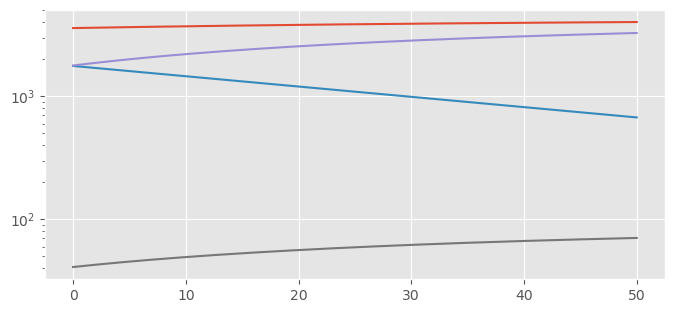

In [36]:
# Plot solution:
plt.figure(figsize=(8,3.5))
#plt.plot(Tₑ,n-sol.y[0].T)
plt.plot(Tₑ * time_scale, sol.y.T * ppl_scales)
#plt.yscale('symlog', linthresh=1e-1)
#plt.xscale('symlog', linthresh=1e-2)
plt.yscale('log')
plt.plot();

At this step we can also test the scalings:

In [37]:
ω = α * [aᵦ/ (ppl_scales * time_scale), aᵧ/time_scale, aₘ/time_scale]

In [38]:
ω,α

(array([4.59706571e-11, 2.63125714e-02, 5.23338714e-04]),
 array([0.07364913, 0.184188  , 0.3663371 ]))

In [39]:
def SIRDn(t, z,  α):
    β, γ, m = α    # Scale parameters
    S, I, R, D = z
    return [β*(ppl_scales*n-S)*I, β*(ppl_scales*n-S)*I - γ*I - m*I, γ*I, m*I]

In [40]:
sol_original_scale = solve_ivp(SIRDn, [0, T*time_scale], ppl_scales * ρ̂ₒ, args=(ω,), 
                                                   t_eval = Tₑ*time_scale, dense_output=True, vectorized=True, rtol=1e-6)
print(sol_original_scale['message'])

The solver successfully reached the end of the integration interval.


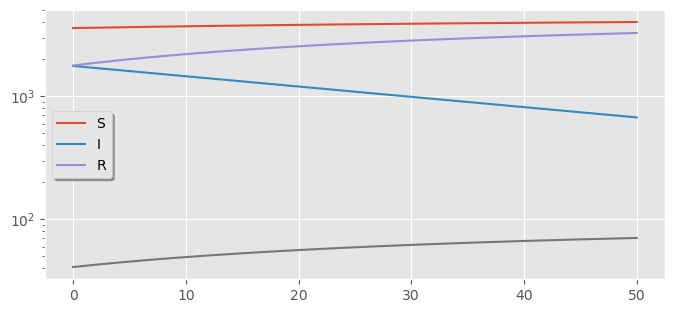

In [41]:
# Plot solution:
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ * time_scale, sol_original_scale.y.T)
#plt.yscale('symlog', linthresh=1e-2)
#plt.xscale('symlog', linthresh=1e-2)
plt.yscale('log')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.show()

## Solve its adjoint

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_\sigma}{\dif t} &= \hat{\sigma} - \sigma + [a_1 \beta] I (q_\sigma + q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I - [a_1 \beta] (n-\sigma)(q_\sigma + q_I) + [a_2\gamma] (q_I - q_R) + [a_3 m] (q_I - q_D),
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
    \\
    \frac{\dif q_D}{\dif t} &= \hat{D} - D,
\end{align}
with the terminal condition $q(T) = \vartheta\big[\rho(T) - \widehat{\rho}(T)\big]$.

In [42]:
# Interpolator from ODE
ρₜ = sol.sol
ρ = sol.y

In [43]:
dw = simpson((ρ̂ - (simpson((ρ̂), x=Tₑ)/T)[::,np.newaxis])**2, x = Tₑ) ** -1    # Goodness of fit weight

In [44]:
def Adjoint(t, z, α,ρ):
    β, γ, m    = [aᵦ,aᵧ,aₘ] * α      # Use scaled interpolator
    S̄, Ī, R̄, D̄ = dw * ρ̄(t)           # Target
    S, I, R, D = dw * ρ(t)           # State
    qₛ, qᵢ, qᵣ, qᵈ = z           # Adjoint
    return [S̄ - S + β*I*(qₛ + qᵢ), Ī - I - β*(n-S)*(qₛ + qᵢ) + γ*(qᵢ - qᵣ) + m * (qᵢ - qᵈ), R̄ - R, D̄ - D]

In [45]:
qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)
solₛ = solve_ivp(Adjoint, [T,0], qₒ, args=(α,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
q = solₛ.y[:,::-1]
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 80 function evaluations.


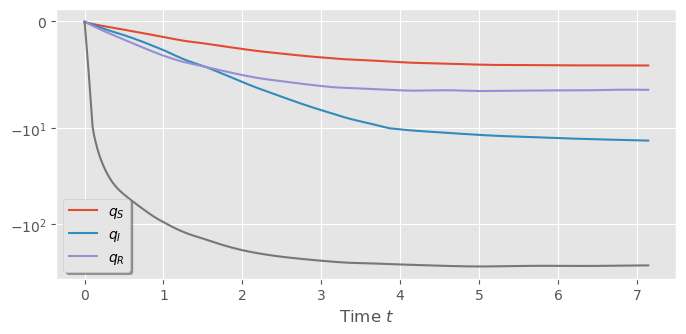

In [46]:
# Plot adjoint curves
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ[::-1],q.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
#plt.yscale('log')
plt.yscale('symlog', linthresh=1e1)
plt.show()

## Cost and gradient

Let us evaluate the function
\begin{align}
    j(\alpha) = \frac{1}{2} \int\limits_0^T w_1 \big( \sigma(t) - \hat{\sigma}(t) \big)^2 +  w_2 \big( I(t) - \hat{I}(t) \big)^2 + w_3 \big( R(t) - \hat{R}(t) \big)^2 + w_4 \big( D(t) - \hat{D}(t) \big)^2 \,\dif t  +  \frac{1}{T} \big( \theta_1 \beta^2 + \theta_2 \gamma^2 + \theta_3 m^2 \big)  + \frac{1}{2} \| \vartheta (\rho(T) - \widehat{\rho}(T)) \|^2_{\R^3}
    .
\end{align}

In [47]:
def Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ,  scale = 1.0):
    # State + controls
    s  = (dw * simpson((ρ-ρ̂)**2, x=Tₑ)).sum()  +  (ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)**2).sum()
    s *= scale
    # Controls
    s +=  (α**2 * θ).sum() / T
    # Weight
    s *= 0.5
    return s

In [48]:
print('As an example, the objective value for α is {0:.4e}.'.format(  Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ, scale = (1) ) ))

As an example, the objective value for α is 3.9747e+00.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T a_1 (n-\sigma) I( q_\sigma + q_I ) \dif t  + \frac{\theta_1}{T} \beta
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T a_2 I( q_R - q_I ) \dif t  + \frac{\theta_2}{T} \gamma
    \\
    \frac{\partial f}{\partial m} &= \int\limits_0^T a_3I (q_D - q_I) \dif t   + \frac{\theta_3}{T} m
\end{align}

In [49]:
df = asarray([aᵦ * simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), aᵧ * simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), aᵧ * simpson(ρ[1] * (q[3]-q[1]), x=Tₑ)])  + (θ/T) * α
print(df)

[-3.53180650e-05  1.34500692e+00 -7.77370112e+01]


### Define projection

In [50]:
def proj(α):    return np.clip(α, 0.0, upper_b)

In [51]:
proj( 7000 * (1-α - 0.82))

array([1.60209, 0.     , 0.     ])

# A few evaluations

Let us evaluate the objective for some curves:

In [52]:
global ρ, q
ρ = np.zeros_like(ρ̂)
q = np.zeros_like(ρ̂)

In [53]:
# Increase tolerance: Quasi-Newton methods are generally more susceptible to numerical errors
# 1e-3 is the default tolerance of the solver, 1e-4 produces fair results and this is replicated in 1e-6
rt = 1e-9
# Scale the population compartments by some quantity; e.g., n^-2 scales by total number of people at time 0
scaling = True
scale = 1.0 if scaling else 1.0

def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ,  scale)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = scale * asarray([ aᵦ * simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), 
                           aᵧ * simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), 
                           aᵧ * simpson(ρ[1] * (q[3]-q[1]), x=Tₑ)]) 
    df += (θ/T) * α
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ,  scale)
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α, θ, ϑᵀᵉʳ,  scale)

    return asarray(f)
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    
        print('Should re-evaluate.')
        plt.plot(ρ_sol.y.T)
        plt.show()
        print(ρ_sol)
    ρᵦ = ρ_sol.y
    f  = Objective(ρᵦ,ρ̂, α, θ, ϑᵀᵉʳ,  scale)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρᵦ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    qᵦ = q_sol.y[:,::-1]

    # Compute derivative
    dF = scale * asarray([ aᵦ * simpson(ρᵦ[0]*ρᵦ[1] * (qᵦ[1]-qᵦ[0]), x=Tₑ),    
                           aᵧ * simpson(ρᵦ[1] * (qᵦ[2]-qᵦ[1]), x=Tₑ),    
                           aₘ * simpson(ρᵦ[1] * (qᵦ[3]-qᵦ[1]), x=Tₑ) ])
    dF += (θ/T) * α

    return asarray(f), dF

In [54]:
obj_eval_a(α)

array(3.97471049)

---

# Solving the optimisation problem

## Optimisation routine

We will use a trust region limited memory algorithm for optimising $j$. In this setting, we will write $x_k$ for the iterates $\alpha_k$.

To control the success of a direction, which is a linear combination of a proximal direction and the previous step, we define the _predicted reduction_ of $f$ as
\begin{align*}
    \mathrm{pred}_k = j(x_k) - q_k(d_k) = -[\nabla f(x_k)]^\top d_k - \frac{1}{2} \langle d_k, B_k d_k \rangle.
\end{align*}
Here we have omited the evaluation of $\imath_{\mathcal{A}}$ at $x_k$ and $x_k + d_k$ (due to the definition of $d_k$). The _actual reduction_ is defined by $\mathrm{ared}_k = j(x_k) - j(x_k + d_k)$.

The first order residual is defined as $r(x) = \mathrm{prox}_{ \imath_\mathcal{A} }\big(x - \nabla f(x) \big) - x$. 

<div class="alert alert-block alert-warning">
Christian Kanzow & Theresa Lechner. Efficient Regularized Proximal Quasi-Newton Methods for Large-Scale Nonconvex Composite Optimization Problems. Pacific Journal of Optimization (to appear). https://arxiv.org/abs/2210.07644
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Regularised Proximal Quasi–Newton Method</h2>
<ol>
<li>Choose \(x_0 \in \mathrm{dom}(j)\) and a symmetric positive definite matrix \(H_0\). 
    Let parameters satisfy \( \mu_0 > 0 \), \( p_{\min} \in (0, 1/2) \), \(\tau_1 \in (0, 1/2) \), \( \tau_2 \in (\tau_1, 1) \), \( \sigma_1 \in (0, 1) \), \( \sigma_2 > 1 \).
    Now set \(m \in \mathbb{N}\), \(k = 0\), and \(B_0 =H_0^{-1}\).
    </li>
    
<p><bf> \(\mathbf{Repeat}\)</bf></p>
    
<ol>
<li>
    Choose \( B_k \in \mathcal{M}_n (\mathbb{R}) \) and find a direction $d_k$ given by the solution to
    \[
        \min_q f(x_k) + \nabla f (x_k)^\top d + \frac{1}{2} d^\top (B_k + \mu_k \mathsf{I}) d + \imath_{\mathcal{A}} (x_k + d)
    \]
</li>
<li> \(\mathbf{If}\) \( \mathrm{pred}_k \leq p_{\min} \|d_k\| \| r(x_k) \| \) \(\mathbf{then}\)
</li>
<ol>
    <li> Set \( \mu_{k} := \sigma_2 \mu_k\), </li>
    <li> Return to step A. </li>
</ol>
<li> \(\mathbf{else}\) </li>
<ol>    
    <li> Go to step D.</li>
</ol>
    
<li> Set \( \rho_k = \mathrm{ared}_k / \mathrm{pred}_k = \dfrac{ f(x_k + d_{k}) - f(x_k)}{ \nabla f(x_k)^\top d_{k} + \frac{1}{2} \, d_{k} ^\top B_k d_{k} } \) and perform the following updates:
    \[
        x_{k+1} = \begin{cases} x_k & \text{if } \rho_k \leq c_1, \\ x_{k} + d_k & \text{otherwise}; \end{cases}
        \qquad
        \mu_{k+1} = 
        \begin{cases}
            \sigma_2 \mu_k & \text{if } \rho_k \leq \tau_1,
            \\
            \mu_k          & \text{if } \tau_1 < \rho_k \leq \tau_2,
            \\
            \sigma_1 \mu_k & \text{if } \rho_k \geq \tau_2.
        \end{cases}
    \]
<ol>
    <li> Let \(\widehat{m} := \min\{k+1,m\}\). </li>
    <li> Update \(B_k\) with the \(n \times \widehat m\) matrices \(S_k\) and \(Y_k\) to get \(B_{k+1} \). </li>
</ol>
</li>
    
<li> Update \( k \leftarrow k+1\) and go to step A.
</li>
    

    

</ol>
    
<p><bf> \(\mathbf{until}\, x_{k}\) satisfies some stopping criteria.</bf></p>
</div>

<div class="alert alert-block alert-warning">
<b>Limited memory</b>
</div>

The limited memory BFGS method approximates the inverse of the Hessian of a functional $j$ at iteration $k+1$, say $H_{k+1}$, without storing the dense matrices $H_k$ at each iteration. Instead, it stores $m$ correction pairs $ \{q_i, d_i\}_{i\in [k-1: k-m]} \subset\mathbb{R}^{n,2} $, where
\begin{equation}
    q_i := x_{i+1} - x_{i}
    \qquad\text{and}\qquad
    d_i := \nabla f(x_{i+1}) - \nabla f(x_{i}),
\end{equation}
that contain information related to the curvature of $f$. Byrd et al (1994) introduced a compact form to define the limited memory matrix $ B_k = H_k^{-1} $ in terms of the $ n\times m $ correction matrices
\begin{equation}
    S_k :=
        \begin{pmatrix}
            q_{k-m} & \cdots & q_{k-1}
        \end{pmatrix}
    \qquad\text{and}\qquad
    Y_k :=
        \begin{pmatrix}
            d_{k-m} & \cdots & d_{k-1}
        \end{pmatrix}.
\end{equation}
%
The main idea of the algorithm is that the matrix $S_k^\top Y_k$ can be written as the sum of the following three matrices:
\begin{equation}
    S_k^\top Y_k = L_k + D_k + R_k,
\end{equation}
where $L_k$ is strictly lower triangular, $D_k$ is diagonal, and $R_k$ is strictly upper triangular.

For $\theta > 0$, if the correction pairs satisfy $ q_i^\top d_i > 0 $, then the matrix obtained by updating $\theta I_n$ with the BFGS formula and the correction pairs after $k$-times can be written as
\begin{align}
    B_k &:= \theta I_n - W_k M_k W_k^\top,
\end{align}
where $W_k$ and $M_k$ are the block matrices given by
\begin{align}
W_k &:= \begin{pmatrix}	Y_k & \theta S_k \end{pmatrix},
\\
M_k &:= \begin{pmatrix}	-D_k & L_k^\top \\  L_k &  \theta S_k^\top S_k	\end{pmatrix}^{-1}.	\label{lbfgs-Bc}
\end{align}
Note that, as $M_k$ is a $2m\times 2m$ matrix, the cost of computing the inverse in the last formula is negligible. Hence, using the compact representation for $B_k$, various computations involving this matrix become inexpensive, as is the case of the product of $B_k$ times a vector.

We skip an update of the method whenever $\langle s_k,y_k\rangle \leq \varepsilon_{\text{LM}} \|s_k\|^2 $.

<div class="alert alert-block alert-warning">
Richard H. Byrd, Jorge Nocedal, and Robert B. Schnabel. Representations of quasi-Newton matrices and their use in limited memory methods. Mathematical Programming, 63(1- 3):129–156, jan 1994.
</div>

## Algorithm

In [55]:
#scale = 1e-0 #1e-4
scale

1.0

In [56]:
def RPQN(α, iters=20, save_iter = False, critical = 1):
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Preamble of functions for limited memory ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    dim = α.size            # dimension of the hyperparameter to optimise 
    '''Reserve memory'''
    cLM   = min(3,dim)
    S     = speye(dim, cLM, format = 'csr').A;                        Y = S.copy()
    SY, O = zeros([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
    
    # LM routines: forward, adjoint, transpose, and projections to active set data
    def Limited():
        def B_eval(W,MI,θᵪ, dk):
            db  = dk.copy();         db *= θᵪ;        db -= W.dot(MI.dot(W.T.dot(dk)));            return db
        def H_eval(WH,MH,θᵪ, dk):
            db  = dk.copy();         db /= θᵪ;        db += WH.dot(MH.dot(WH.T.dot(dk)));          return db
        return B_eval, H_eval
    
    # Limited memory functions (two options are available LBFGS or LSR1)
    def LBFGS(S,Y,SY, θ):
        W   = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        M0  = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);    MM = append(M0,M1, axis=0)
        MI  = inv(MM)
        WH  = W.copy();       WH /= θ;    R = inv(triu(SY,k=0));            MH0 = append(O, -R, axis=1)
        MH1 = append(-R.T, R.T.dot((D + Y.T.dot(Y)/θ).dot(R)), axis=1);     MH  = append(MH0,MH1, axis=0)
        return MI, MH, W, WH
    def LSR1(S,Y,SY, θ):
        W  = Y - θ*S;  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        MM = D + L + L.T - θ*S.T.dot(S);    MM *= -1
        while np.linalg.det(MM) == 0.0:
            # Backtracking
            θ *= 0.5
            W  = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
            M0 = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);     MM = append(M0,M1, axis=0)
        MI = inv(MM)
        WH = W.copy();    WH /= θ;    R = triu(SY,k=0)
        MH = inv( R + R.T - D - (1.0/θ)*Y.T.dot(Y))
        return MI, MH, W, WH
    
    Method = 'BFGS'
    
    # Initialise a Gurobi instance for linear solves
    TR_sub = GRB.Model('TR subproblem')
    #TR_sub.Params.Presolve = 0
    TR_sub.setParam('OutputFlag', 0)
    pᵀᴿ = TR_sub.addMVar(shape = dim, vtype = 'C', name = 'p', lb = 0.0, ub = upper_b)
    TR_sub.update()
    
    # Define constraints as a polytope (not needed)
    #Aₚ = bmat([[-speye(dim,format='csr')],[speye(dim,format='csr')]])
    #bₚ = concatenate((zeros(dim), ones(dim)))
    
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Create structures to store information from iterates ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    if save_iter:
        every_iter = {a:[] for a in ['it', 'obj', 'time',   'β', 'γ', 'm',  'df_β', 'df_γ', 'df_m', 'norms']}
        every_iter['norms'] = {a:[] for a in ['ℓ_1', 'ℓ_2', 'max', 'min']}
    else:  every_iter = {}
    
    best = {'obj': 1e+10, 'α': None, 'df': None}

    
    ''' 
        \\\\\\\\\\\\\\\\\\\\\\
        *** Initialisation ***
        \\\\\\\\\\\\\\\\\\\\\\
    '''
    xₖ = α.copy()      # IMPORTANT to avoid clash with the α defined below (!!!)
    

    # All objects involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.
    
    ''' Setting TR parameters '''
    σᵪ = [0.4, 4.0]                  # TR scaling factors  0 < σᵪ[0] < 1 < σᵪ[1] (p 24)
    τᵪ = [1e-4,0.5]                  # TR acceptance ratio (Fail, Success & Increase regions)  0 < τᵪ[0] < τᵪ[1] < 1, τᵪ[0] < ½   [this is c]
    pᵪ = 1e-8                        # Predicted reduction threshold   [this is pₘᵢₙ]
    Δᵪ = 1.0                         # TR radii: μₖ
    θᵪ = 5.0                         # Initial weight for basic Hessian approximation
    mᵪ = 15                           # Memory

    ''' Additional tolerances '''
    εᵪ_LM    = 1e-8                  # Tolerance of curvature sₖᵀyₖ > ε
    εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
    εᵪ_H     = 1e-17                 # Himmeblau criteria
    εᵪ_S     = 1e-18                 # Stationarity criterion
    
    ''' Initial iteration (xₒ, fₒ, dfₒ) '''
    fₖ, dfₖ  = obj_eval(xₖ)
    ''' Initial iteration counter and maximum number of iterations '''
    kᵪ      = 0;
    Max_It  = iters
    
    
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Run algorithm for the given settings ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    timed = 0.0              # Clock
    
    kᵪ = 0                      # Iteration count
    kᵢₙₙₑᵣ = 0                   # Subcounter from TR iteration
    while True:

        # Print header of table
        if max(kᵪ,kᵢₙₙₑᵣ) == 0 :
            #print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|'.format('#','‖β‖', '‖γ‖', '‖m‖'), end='')
            print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|'.format('#','β', 'γ', 'm'), end='')
            print('{0:^11s}|{1:^11s}|{2:^11s}|'.format('j(α)','ᵣ‖∇j(α)‖₂','ᵣ‖∇j(α)‖∞'), end='')
            print('{0:^11s}|{1:^11s}|{2:^11s}'.format('μₖ','ᵣ‖d‖₂', 'Time'))
            #print('–'*121)
            print('–'*110)

            # Report initial iteration info
            if save_iter:
                every_iter['it'].append( kᵪ )
                every_iter['obj'].append( fₖ )
                every_iter['time'].append( timed )
                every_iter['β'].append( xₖ[0] )
                every_iter['γ'].append( xₖ[1] )
                every_iter['m'].append( xₖ[2] )
                every_iter['df_β'].append( dfₖ[0] )
                every_iter['df_γ'].append( dfₖ[1] )
                every_iter['df_m'].append( dfₖ[2] )
                # Store norms of gradient
                every_iter['norms']['ℓ_2'].append( norm(dfₖ.ravel())/(dim**0.5) )
                every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/dim )
                every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
                every_iter['norms']['min'].append( abs(dfₖ).min() )
            # Store best point
            if fₖ < best['obj']:
                best['obj'] = fₖ
                best['α']   =  xₖ.copy()
                best['df']  = dfₖ.copy()

            '''xₑₙ = xₖ.Ens**0.5
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ-1, xₑₙ[0], xₑₙ[1], xₑₙ[2], fₖ,
                                                                norm(dfₖ.ravel())/(3*T**0.5), norm(dfₖ.ravel(), np.inf)) )'''
            
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1], xₖ[2]), end = '' )
            print('{0:^11.3e}|{1:^11.3e}|{2:^11.3e}|'.format( fₖ, norm(dfₖ.ravel())/(dim**0.5), norm(dfₖ.ravel(), np.inf) ) )
        
        it_time = time.time()                                             # Clock
        
        # *************** #
        # 1. Find direction
        
        # ––––––––– #
        # Limited memory matrix and operators
        MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ) if (Method == 'BFGS') else LSR1(S,Y,SY, θᵪ)        # Bₖ
        B_eval, H_eval = Limited()
        
        oᵀᴿ = 0.5 * pᵀᴿ @ ((θᵪ+Δᵪ) * pᵀᴿ - W @ (MI @ (W.T @ pᵀᴿ)))             # Define quadratic part of objective, we use Bₖ + μₖ I
        TR_sub.setObjective(oᵀᴿ + (dfₖ @ pᵀᴿ) + fₖ, 1)                          # Add objective and optimisation sense (minimise)
        #TR_sub.update();          print(TR_sub.getObjective())
        pᵀᴿ.LB = 1e-6-xₖ;        pᵀᴿ.UB = upper_b - xₖ                              # Fix feasibility bounds
        #TR_sub.update();          print(pᵀᴿ.LB, pᵀᴿ.UB)
        
        # ––––––––– #
        # Solve subproblem        # TR_sub.addConstr( Aₚ.dot(pᵀᴿ) <= bₚ[::,np.newaxis] );
        #TR_sub.setParam('NumericFocus',3)
        TR_sub.optimize()
        
        dₖ  = pᵀᴿ.x
        Tfₖ, Tdfₖ = obj_eval_d(xₖ + dₖ)                                          # Evaluate direction to be tested
        #print(dfₖ, Tdfₖ)
        #print(kᵪ,   xₖ, dₖ, xₖ + dₖ, Tfₖ)
        
        # ––––––––– #
        # Compute predicted reduction
        pred = -dfₖ.dot(dₖ) - 0.5 * dₖ.dot( B_eval(W,MI,θᵪ, dₖ) )
        rₖ   = proj( xₖ - dfₖ  ) - xₖ
        
        # ––––––––– #
        # Test reduction
        if pred <= pᵪ * norm(dₖ) * norm(rₖ):
            Δᵪ *= σᵪ[1]                                                        # Increase penalisation
            if kᵢₙₙₑᵣ == 0:
                print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
            #print(kᵪ,  pred, pᵪ * norm(dₖ) * norm(rₖ))
            print('\033[0;33;2m {0:5.3e} \x1b[0m'.format(Δᵪ), end = ' ')       # Print updated radius
            kᵢₙₙₑᵣ += 1
            
            if Δᵪ > 1e+18: #norm(dₖ) < εᵪ_S:
                print('\033[10;42;1m  No more directions  \033[10;42;1m')
                break
        else:
            # *************** #
            # 2. TR update
            
            # ––––––––– #
            # TR reduction ratio
            ρₖ = (fₖ - Tfₖ)/pred
            #print(kᵪ,  ρₖ, τᵪ[0])
            
            # ––––––––– #
            # Test TR:
            if      ρₖ <= τᵪ[0]:
                Δᵪ *= σᵪ[1]                                                    # Increase penalisation
                if kᵢₙₙₑᵣ == 0:
                    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
                print('\033[0;33;2m {0:5.3e} \x1b[0m'.format(Δᵪ), end = ' ')   # Print updated radius
                kᵢₙₙₑᵣ += 1
                
                if Δᵪ > 1e+18: #norm(dₖ) < εᵪ_S:
                    print('\033[10;42;1m  No more directions  \033[10;42;1m')
                    break
            
            else:
                # ––––––––– #
                # Update LM info
                sₖ  = dₖ.copy()                                                 # Point difference (xₖ + dₖ) - xₖ = dₖ
                yₖ  = Tdfₖ - dfₖ                                                # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
                #yₖ.shape, sₖ.shape = (dim,), (dim,)                            # Inplace reshape
                
                # Update LM matrices according to curvature
                ϕᵪ = sₖ.dot(yₖ)                                                 # Compute curvature
                if ϕᵪ >= εᵪ_LM * sₖ.dot(sₖ):
                    θᵪ  = sₖ.dot(yₖ) / yₖ.dot(yₖ)                                # Barzilai-Borwein
                    #print(θᵪ)
                    cLM = min(S.shape[1], mᵪ)                                  # Current LM size
                    
                    if cLM < mᵪ:        # If size is small, add column with secant information
                        S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
                        cLM  += 1 
                        SY, O = zeros([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
                    else:               # If size is too large, drop first column
                        S = append(S[:,1:], sₖ[:,None], axis=1)
                        Y = append(Y[:,1:], yₖ[:,None], axis=1)
                    
                
                # ––––––––– #
                # Accept step
                kᵪ += 1
                Hi_rv = abs(fₖ - Tfₖ)/fₖ if (abs(fₖ) > εᵪ_HCond) else abs(fₖ - Tfₖ)            # Relative variation for Himmeblau
                
                xₖ += dₖ
                fₖ, dfₖ = Tfₖ, Tdfₖ.copy()
                
                # ––––––––– #
                # Check if penalisation can be reduced
                if  ρₖ > τᵪ[1]:
                    Δᵪ *= σᵪ[0]
                
                # *************** #
                # Measure time up to this point!
                end = time.time()
                timed += end - it_time
                
                # Reset inner iteration counter
                if kᵢₙₙₑᵣ > 0:
                    print('')
                    kᵢₙₙₑᵣ = 0                # Reset counter
                
                # *************** #
                # Storage and display
                # ––––––––– #
                # Store progress
                if save_iter:
                    every_iter['it'].append( kᵪ )
                    every_iter['obj'].append( fₖ );        every_iter['time'].append( timed )
                    every_iter['β'].append( xₖ[0] );       every_iter['γ'].append( xₖ[1] );        every_iter['m'].append( xₖ[2] )
                    every_iter['df_β'].append( dfₖ[0] );   every_iter['df_γ'].append( dfₖ[1] );    every_iter['df_m'].append( dfₖ[2] )
                    # Store norms of gradient
                    every_iter['norms']['ℓ_2'].append( norm(dfₖ.ravel())/(dim**0.5) )
                    #every_iter['norms']['ℓ_1'].append( (1.0/(3*T)) * norm(dfₖ.ravel(),1) )
                    every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/dim )
                    every_iter['norms']['max'].append( norm(dfₖ.ravel(), np.inf) )
                    every_iter['norms']['min'].append( abs(dfₖ.ravel()).min() )
                # Store best point
                if fₖ < best['obj']:
                    best['obj'] = fₖ
                    best['α']   =  xₖ.copy()
                    best['df']  = dfₖ.copy()
                
                # Display progress
                if kᵪ % critical == 0:
                    '''xₑₙ = xₖ.Ens**0.5
                    print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ-1, xₑₙ[0], xₑₙ[1], xₑₙ[2], fₖ,
                                                                        norm(dfₖ.ravel())/(3*T**0.5), norm(dfₖ.ravel(), np.inf)) )'''

                    print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1] ,xₖ[2]), end = '' )
                    print('{0:^11.3e}|{1:^11.3e}|{2:^11.3e}|'.format( fₖ, norm(dfₖ.ravel())/(dim**0.5), norm(dfₖ.ravel(), np.inf) ), end = '' )
                    print('{0:^11.3e}|{1:^11.3e}|{2:^11.3g}'.format(Δᵪ, norm(dₖ.ravel())/(dim**0.5), timed))
            
            
                # *************** #
                # Stopping criteria
                # ––––––––– #
                # Himmeblau stopping criterion
                if Hi_rv < εᵪ_H:
                    print('\033[10;42;1m  Himmeblau  \033[10;42;1m')
                    break
                # ––––––––– #
                # Near optimality
                if norm(dₖ) < εᵪ_S:
                    print('\033[10;42;1m  Stationary  \033[10;42;1m')
                    break
                
                
            #print(kᵪ,  xₖ, ρₖ, fₖ)
            #print(kᵪ,  xₖ, fₖ)
        
        # ¡Stop! Maximum iteration count is reached
        if kᵪ == Max_It:
            print('\033[10;41;1m  Maxiter  \033[10;41;1m')
            break

    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Finalise and report *** 
        \\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))
    print('\x1b[0m')
    
    # Recompute best objective and state:
    α = best['α']
    jα = obj_eval_a(α)
    #print(α.En, jα)
    print(α, jα)
    
    return α, ρ, every_iter, best

In [57]:
#ϑᵀᵉʳ = 1e+1 #np.asarray([1e-4,1e-4,5e+2])
#θ = 1e-8 * np.ones(3)[::,np.newaxis] #np.asarray([1e-6,1e-8,1e-9])[::,np.newaxis]

In [58]:
upper_b

array([1.60209, 0.7    , 7.     ])

In [59]:
from sklearn.metrics import r2_score

In [58]:
ᾱ, ρ, every_iter, best = RPQN(asarray([0.68679323, 0.1799, 7.7]), iters=2000, save_iter = True, critical = 1)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-26
  #  |     β     |     γ     |     m     |   j(α)    | ᵣ‖∇j(α)‖₂ | ᵣ‖∇j(α)‖∞ |    μₖ     |   ᵣ‖d‖₂   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  0  | 6.868e-01 | 1.799e-01 | 7.700e+00 | 1.222e+02 | 1.548e+03 | 2.509e+03 |
  1  | 6.731e-01 | 7.000e-01 | 1.000e-06 | 3.670e+00 | 1.411e+00 | 2.297e+00 | 1.000e+00 | 4.456e+00 |  0.0699   
  2  | 6.731e-01 | 6.514e-01 | 1.000e-06 | 3.549e+00 | 1.649e+00 | 2.699e+00 | 4.000e-01 | 2.806e-02 |   0.129   
  3  | 6.731e-01 | 5.936e-01 | 1.000e-06 | 3.377e+00 | 1.993e+00 | 3.281e+00 | 1.600e-01 | 3.339e-02 |   0.188   
  4  | 6.730e-01 | 5.229e-01 | 1.000e-06 | 3.115e+00 | 2.519e+00 | 4.169e+00 | 6.400e-02 | 4.080e-02 |   0.244   
  5  | 6.730e-01 | 4.329e-01 | 1.000e-06 | 2.678e+00 | 3.358e+00 | 5.572e+00 | 2.560e-02 | 5.195e-02 |   0.297   
  6  | 6.730e-01 | 3.126e-01 | 1.00

In [59]:
print(1 - (simpson((ρ-ρ̂)**2, x=Tₑ) * dw), '  ', r2_score(ρ̂,ρ, sample_weight=dw))

[0.9387148  0.85599728 0.96580915 0.92083303]


Increased τᵪ from 0.1:

In [60]:
ᾱ, ρ, every_iter, best = RPQN(asarray([0.68679323, 0.1799, 7.7]), iters=2000, save_iter = True, critical = 2)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-26
  #  |     β     |     γ     |     m     |   j(α)    | ᵣ‖∇j(α)‖₂ | ᵣ‖∇j(α)‖∞ |    μₖ     |   ᵣ‖d‖₂   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  0  | 6.868e-01 | 1.799e-01 | 7.700e+00 | 1.222e+02 | 1.548e+03 | 2.509e+03 |
  2  | 6.731e-01 | 6.514e-01 | 1.000e-06 | 3.549e+00 | 1.649e+00 | 2.699e+00 | 4.000e-01 | 2.806e-02 |   0.116   
  4  | 6.730e-01 | 5.229e-01 | 1.000e-06 | 3.115e+00 | 2.519e+00 | 4.169e+00 | 6.400e-02 | 4.080e-02 |   0.229   
  6  | 6.730e-01 | 3.126e-01 | 1.000e-06 | 1.897e+00 | 4.369e+00 | 7.156e+00 | 1.024e-02 | 6.949e-02 |   0.336   
  8  | 6.733e-01 | 1.286e-01 | 5.130e-01 | 4.647e-01 | 8.417e+00 | 1.455e+01 | 1.638e-03 | 2.967e-01 |   0.445   
 TR-radius:  6.554e-03   2.621e-02   1.049e-01   4.194e-01   1.678e+00   6.711e+00   2.684e+01   1.074e+02  
 10  | 6.733e-01 | 1.891e-01 | 5.138e-01

In [61]:
print(1 - (simpson((ρ-ρ̂)**2, x=Tₑ) * dw), '  ', r2_score(ρ̂,ρ, sample_weight=dw))

[0.93880148 0.85599952 0.96580294 0.92083093]    0.9629059581619821


In [62]:
ᾱ, ρ, every_iter, best = RPQN(α, iters=2000, save_iter = True, critical = 1)

  #  |     β     |     γ     |     m     |   j(α)    | ᵣ‖∇j(α)‖₂ | ᵣ‖∇j(α)‖∞ |    μₖ     |   ᵣ‖d‖₂   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  0  | 7.365e-02 | 1.842e-01 | 3.663e-01 | 3.975e+00 | 4.565e+01 | 7.906e+01 |
 TR-radius:  4.000e+00   1.600e+01   6.400e+01  
  1  | 7.365e-02 | 1.627e-01 | 1.583e+00 | 3.409e+00 | 7.297e-01 | 1.262e+00 | 6.400e+01 | 7.023e-01 |  0.0627   
  2  | 7.365e-02 | 1.433e-01 | 1.583e+00 | 3.386e+00 | 6.398e-01 | 1.107e+00 | 2.560e+01 | 1.121e-02 |   0.129   
  3  | 7.365e-02 | 1.103e-01 | 1.584e+00 | 3.356e+00 | 4.121e-01 | 7.128e-01 | 1.024e+01 | 1.906e-02 |   0.192   
  4  | 7.365e-02 | 7.804e-02 | 1.582e+00 | 3.342e+00 | 1.016e-01 | 1.377e-01 | 4.096e+00 | 1.862e-02 |   0.251   
  5  | 7.366e-02 | 7.268e-02 | 1.580e+00 | 3.341e+00 | 8.971e-02 | 1.551e-01 | 1.638e+00 | 3.416e-03 |   0.311   
  6  | 7.367e-02 | 6.949e-02 | 1.575e+00 | 3.340e+00 | 1.023e-01 | 1.627e-01 

 65  | 2.925e-01 | 1.304e-02 | 7.436e-01 | 2.073e+00 | 3.702e-02 | 6.346e-02 | 5.986e-12 | 1.056e-02 |   3.81    
 66  | 3.032e-01 | 1.464e-02 | 7.282e-01 | 1.999e+00 | 4.440e-02 | 7.637e-02 | 2.395e-12 | 1.083e-02 |   3.87    
 67  | 3.145e-01 | 1.654e-02 | 7.128e-01 | 1.920e+00 | 5.191e-02 | 8.946e-02 | 9.578e-13 | 1.113e-02 |   3.92    
 68  | 3.264e-01 | 1.874e-02 | 6.971e-01 | 1.836e+00 | 6.157e-02 | 1.063e-01 | 3.831e-13 | 1.142e-02 |   3.98    
 69  | 3.391e-01 | 2.134e-02 | 6.814e-01 | 1.746e+00 | 7.174e-02 | 1.239e-01 | 1.532e-13 | 1.176e-02 |   4.03    
 70  | 3.526e-01 | 2.434e-02 | 6.656e-01 | 1.651e+00 | 8.397e-02 | 1.452e-01 | 6.130e-14 | 1.212e-02 |   4.09    
 71  | 3.669e-01 | 2.784e-02 | 6.498e-01 | 1.549e+00 | 9.739e-02 | 1.685e-01 | 2.452e-14 | 1.248e-02 |   4.15    
 72  | 3.823e-01 | 3.188e-02 | 6.338e-01 | 1.441e+00 | 1.135e-01 | 1.964e-01 | 9.808e-15 | 1.300e-02 |   4.21    
 73  | 3.984e-01 | 3.656e-02 | 6.186e-01 | 1.328e+00 | 1.303e-01 | 2.255e-01 | 3.923e-15

 TR-radius:  1.009e-03   4.035e-03   1.614e-02   6.456e-02   2.582e-01   1.033e+00   4.132e+00   1.653e+01   6.611e+01  
 125 | 6.750e-01 | 1.765e-01 | 4.843e-01 | 1.645e-01 | 1.342e-01 | 1.685e-01 | 2.644e+01 | 4.354e-03 |   7.26    
 126 | 6.750e-01 | 1.760e-01 | 4.884e-01 | 1.639e-01 | 7.112e-02 | 1.220e-01 | 1.058e+01 | 2.364e-03 |   7.31    
 127 | 6.750e-01 | 1.763e-01 | 4.951e-01 | 1.632e-01 | 4.299e-02 | 7.309e-02 | 4.231e+00 | 3.923e-03 |   7.37    
 128 | 6.750e-01 | 1.768e-01 | 5.018e-01 | 1.629e-01 | 1.677e-02 | 2.838e-02 | 1.692e+00 | 3.839e-03 |   7.43    
 129 | 6.749e-01 | 1.771e-01 | 5.051e-01 | 1.628e-01 | 3.494e-03 | 6.018e-03 | 6.769e-01 | 1.956e-03 |   7.48    
 130 | 6.749e-01 | 1.771e-01 | 5.060e-01 | 1.628e-01 | 2.884e-03 | 4.914e-03 | 2.708e-01 | 4.656e-04 |   7.53    
 131 | 6.748e-01 | 1.771e-01 | 5.061e-01 | 1.628e-01 | 7.304e-03 | 1.263e-02 | 1.083e-01 | 8.101e-05 |   7.59    
 132 | 6.746e-01 | 1.770e-01 | 5.061e-01 | 1.627e-01 | 1.697e-02 | 2.935e-02 | 4.

In [63]:
print(1 - (simpson((ρ-ρ̂)**2, x=Tₑ) * dw), '  ', r2_score(ρ̂,ρ, sample_weight=dw))

[0.9388062  0.85600077 0.96580261 0.92082964]    0.9629017280032005


---

In [64]:
simpson((ρ-ρ̂)**2, x=Tₑ).sum(),  ϑᵀᵉʳ * ((ρ[:,-1] - ρ̂ᶠ)**2) 

(0.06599081379835904,
 array([2.24977272e-03, 2.80621391e-03, 4.20986595e-05, 8.95687206e-07]))

In [65]:
((ρ[:,-1] - ρ̂ᶠ))

array([ 0.14999242,  0.16751758, -0.02051796,  0.0029928 ])

---

---

In [62]:
#CMap = get_cmap('Wistia')
CMap = colormaps['BuGn']
colours_nmAPG = CMap(150)

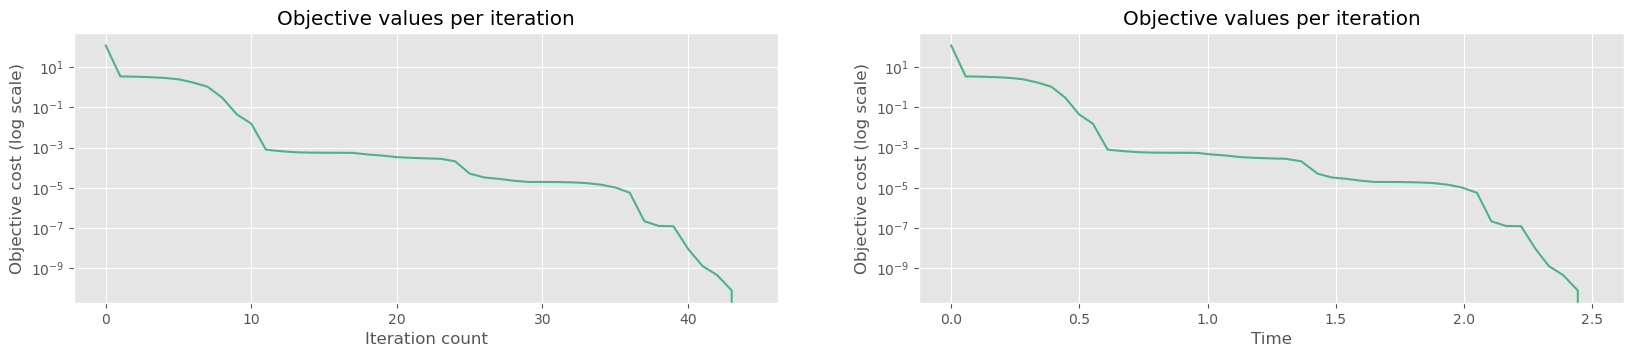

In [63]:
# Visualise evolution of objective values
plt.figure(figsize = (20,3.5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'] - min(every_iter['obj']), c = colours_nmAPG)
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']), c = colours_nmAPG)
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

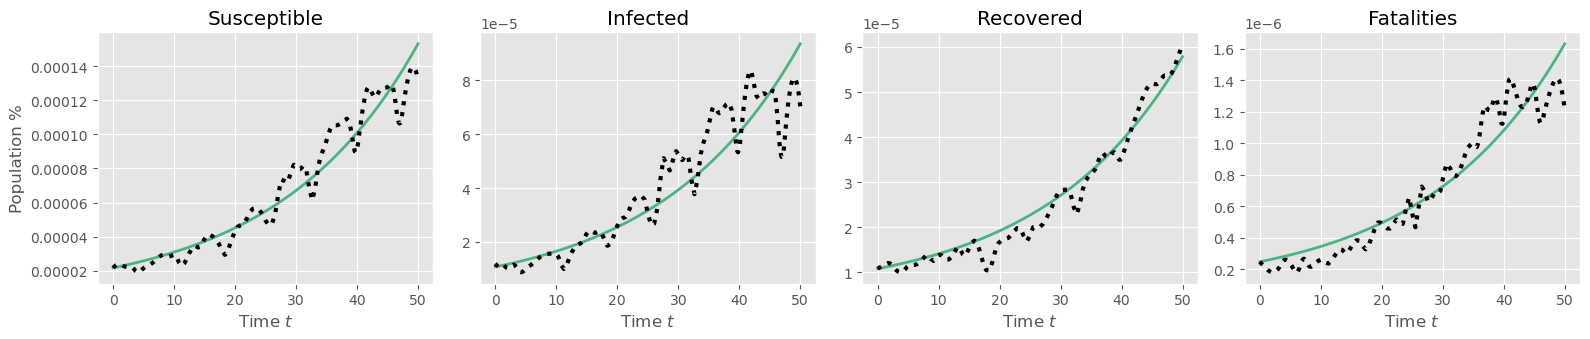

In [64]:
# Plot state 
fig, ax = plt.subplots(1, 4, figsize=(16, 3.5))
#fig, ax = plt.subplots(1, 4, figsize=(12, 3))

# Add state
ax[0].plot(Tₑ*7, ρ[0]/n, '-', c=colours_nmAPG, linewidth=2)
#ax[0].plot(Tₑ*7, 1-ρ[0]/n, '-', c=colours_nmAPG, linewidth=2)
ax[1].plot(Tₑ*7, ρ[1]/n, '-', c=colours_nmAPG, linewidth=2)
ax[2].plot(Tₑ*7, ρ[2]/n, '-', c=colours_nmAPG, linewidth=2)
ax[3].plot(Tₑ*7, ρ[3]/n, '-', c=colours_nmAPG, linewidth=2)
    
# Add target
ax[0].plot(Tₑ*7, ρ̂[0]/n, ':', c='black', linewidth=3)
ax[1].plot(Tₑ*7, ρ̂[1]/n, ':', c='black', linewidth=3)
ax[2].plot(Tₑ*7, ρ̂[2]/n, ':', c='black', linewidth=3)
ax[3].plot(Tₑ*7, ρ̂[3]/n, ':', c='black', linewidth=3)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')
ax[3].set_xlabel(r'Time $t$');    ax[3].set_title(r'Fatalities')

ax[0].set_ylabel('Population %')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/BD - Scalar.pdf', bbox_inches='tight', pad_inches=0)

In [65]:
obj_eval(ᾱ);

In [66]:
df

array([1.87913343e-05, 1.88886544e-05, 7.90819137e-04])

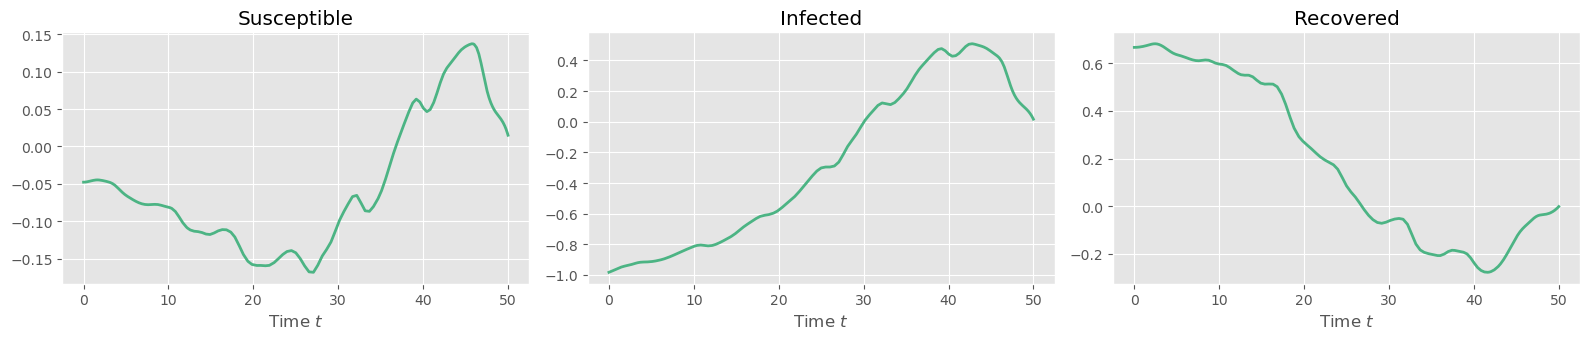

In [67]:
# Plot adjoint
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, q[0], '-', c=colours_nmAPG, linewidth=2)
ax[1].plot(Tₑ*7, q[1], '-', c=colours_nmAPG, linewidth=2)
ax[2].plot(Tₑ*7, q[2], '-', c=colours_nmAPG, linewidth=2)
    

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')



#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

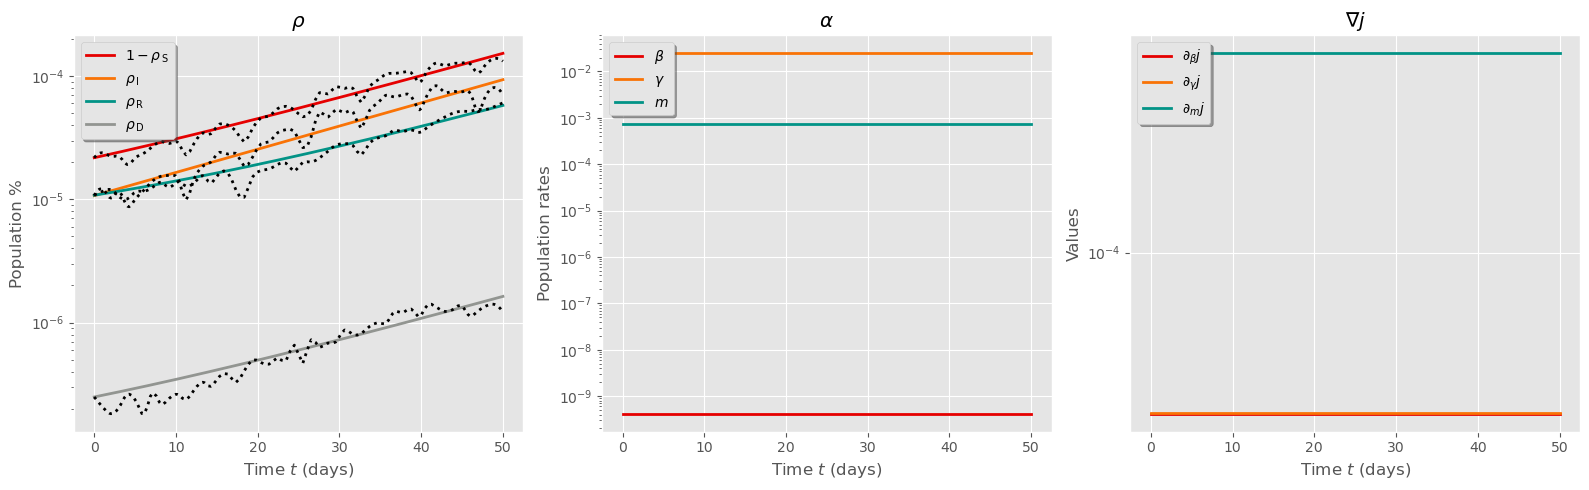

In [68]:
# Plot state 
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
colors = ['xkcd:red','xkcd:orange','xkcd:teal','xkcd:gray']

# Add state
ax[0].plot(Tₑ*7, ρ[0].T * ppl_scales / SIRD_data[0].sum(), '-', linewidth=2)
ax[0].plot(Tₑ*7, ρ[1:].T* ppl_scales / SIRD_data[0].sum(), '-', linewidth=2)
for i, line in enumerate(ax[0].get_lines()):    line.set_color(colors[i])
ax[0].legend(['$1-ρ_{\,\mathsf{S}}$', '$ρ_{\,\mathsf{I}}$', '$ρ_{\,\mathsf{R}}$', '$ρ_{\,\mathsf{D}}$'], shadow=True, loc='upper left')

ax[0].plot(Tₑ*7, ρ̂[0].T * ppl_scales/SIRD_data[0].sum(), ':', c='black', linewidth=2)
ax[0].plot(Tₑ*7, ρ̂[1:].T* ppl_scales/SIRD_data[0].sum(), ':', c='black', linewidth=2)

ax[1].plot(Tₑ*7, ᾱ[0]*aᵦ/(time_scale*ppl_scales) * ones(Tₑ.size), '-', c='xkcd:red', linewidth=2)   #scale to original units
ax[1].plot(Tₑ*7, ᾱ[1]*aᵧ/time_scale * ones(Tₑ.size), '-', c='xkcd:orange', linewidth=2)
ax[1].plot(Tₑ*7, ᾱ[2]*aₘ/time_scale * ones(Tₑ.size), '-', c='xkcd:teal', linewidth=2)
ax[1].legend(['$β$', '$γ$', '$m$'], shadow=True, loc='upper left')

ax[2].plot(Tₑ*7, df[0]  * ones(Tₑ.size), '-', c='xkcd:red', linewidth=2)
ax[2].plot(Tₑ*7, df[1] * ones(Tₑ.size), '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, df[2] * ones(Tₑ.size), '-', c='xkcd:teal', linewidth=2)
ax[2].legend(['$\partial_β j$', '$\partial_γ j$', '$\partial_m j$'], shadow=True, loc='upper left')


ax[0].set_xlabel(r'Time $t$ (days)');    ax[0].set_title(r'$\rho$')
ax[1].set_xlabel(r'Time $t$ (days)');    ax[1].set_title(r'$\alpha$')
ax[2].set_xlabel(r'Time $t$ (days)');    ax[2].set_title(r'$\nabla j$')

ax[0].set_ylabel('Population %')
ax[1].set_ylabel('Population rates')
ax[2].set_ylabel('Values')

ax[0].set_yscale('log')#, linthresh=1e-2)
ax[1].set_yscale('log')
#ax[1].set_ylim([1e-8, 30*ᾱ.data[2].max()])

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    
ax[2].set_yscale('symlog', linthresh=1e-5)

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/DD – Panels – RPQN - H.pdf', bbox_inches='tight', pad_inches=0)

In [69]:
(aᵧ * ᾱ[1] + aₘ * ᾱ[2]).max() /(time_scale * ppl_scales)

1.1064352376743798e-06

---

### Store

In [70]:
every_iter['obj'] = asarray(every_iter['obj'])
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail())
#
#df_every.to_pickle('Outputs/DD – RPQN - Every - H.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
40,40,0.16183,2.278411,0.667998,0.172210,0.505743,0.000019,0.000864,-0.000039,0.000307,0.000500,0.000864,0.000019
41,41,0.16183,2.330442,0.667996,0.172205,0.505741,0.000019,0.000137,0.000002,0.000052,0.000080,0.000137,0.000002
42,42,0.16183,2.386074,0.667995,0.172205,0.505741,0.000019,0.000090,-0.000004,0.000038,0.000053,0.000090,0.000004
43,43,0.16183,2.443435,0.667994,0.172204,0.505742,0.000019,0.000034,0.000006,0.000019,0.000023,0.000034,0.000006
44,44,0.16183,2.497674,0.667994,0.172203,0.505742,0.000019,0.000019,0.000008,0.000015,0.000016,0.000019,0.000008


In [71]:
# Store info from iterate with smallest objective
ArgMin_nmAPG = df_every.idxmin()['obj']
#Out_θ = 
df_every.loc[[ArgMin_nmAPG]].rename(index={ArgMin_nmAPG:θ}).copy()

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
"[1e-09, 1e-09, 1e-09]",44,0.16183,2.497674,0.667994,0.172203,0.505742,0.000019,0.000019,0.000008,0.000015,0.000016,0.000019,0.000008


In [72]:
asarray([0.66799418, 0.17220347, 0.50574162]) * [aᵦ/(time_scale*ppl_scales), aᵧ/time_scale, aₘ/time_scale]

array([4.16951719e-10, 2.46004957e-02, 7.22488029e-04])

---

In [62]:
#np.savez_compressed('Outputs/DD – RPQN – Best - H', best = best)

In [63]:
#np.load('Outputs/DD – nmAPG – Best.npz', allow_pickle=True)['best']

---